# Group 14 - Project FP01
## Time series anomaly detection - LSTM-ED

This project aims at investigating the current state-of-the-arts TAD scenario.

In [40]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [41]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import get_df_action, get_features_ts, get_train_test_data, label_collision_data, predict_anomaly_score
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve, plot_all_anomalies_over_time
from metrics import Confidence, anomaly_detection_metric, compute_metrics, compute_various_thresholds

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [42]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [43]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

collisions_adjusted = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')
collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')

# transform in like collision
collisions['Timestamp'] = collisions_adjusted
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collision_rec5['Timestamp'] = collisions_adjusted_rec_5

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



In [44]:
# plot_signals(df, df_action, "Normal signals", saveplot=False)
# plot_signals(df_collision, df_action_collision, "Collision signals", saveplot=False)
# plot_signals(df_collision_1, df_action_collision_1, "Collision signals 1", saveplot=False)
# plot_signals(df_collision_5, df_action_collision_5, "Collision signals 5", saveplot=False)

### Features Exctraction

In [45]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1)
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
Computing features.


Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 180.1431200504303 seconds ---


In [46]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

In [47]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_adjusted_rec_1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_adjusted_rec_5)

In [48]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']


## LSTM-ED

In [49]:
from algorithms.lstm_enc_dec_axl import LSTMED

classifier = LSTMED(
    name='LSTM-ED',
    num_epochs=100,
    batch_size=64,
    lr=1e-4,
    hidden_size=64,
    sequence_length=100,
    train_gaussian_percentage=0.25,
    n_layers=(2, 2),
    use_bias=(True, True),
    dropout=(0.1, 0.1),
    seed=42,
    gpu=None,              # Set to None for CPU, or specify GPU index if available
    details=True
)
# Train the LSTM on normal data
classifier.fit(X_train)
print("LSTM-ED training completed.")


100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


LSTM-ED training completed.


In [50]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [51]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 1 with threshold 15011868905.997667, std
Number of anomalies detected: 125 with threshold 171.52736589910097, mad
Number of anomalies detected: 16 with threshold 941.1570747341766, percentile
Number of anomalies detected: 6 with threshold 1242.4522328390067, IQR

Number of anomalies detected: 1 with threshold 20686214238.439953, std
Number of anomalies detected: 46 with threshold 136.5349628904395, mad
Number of anomalies detected: 9 with threshold 855.0793137810648, percentile
Number of anomalies detected: 24 with threshold 374.0568733390154, IQR

Number of anomalies detected: 4 with threshold 1147.3382176997163, std
Number of anomalies detected: 2 with threshold 1205.9529402372827, mad
Number of anomalies detected: 8 with threshold 1024.2980260985257, percentile
Number of anomalies detected: 0 with threshold 1652.464244355928, IQR



### Anomaly Detection

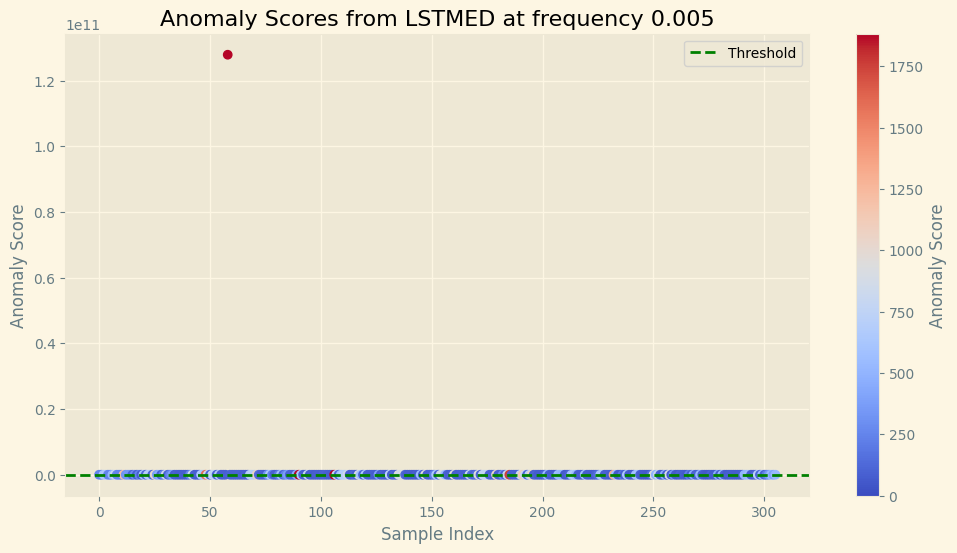

Number of anomalies detected: 16


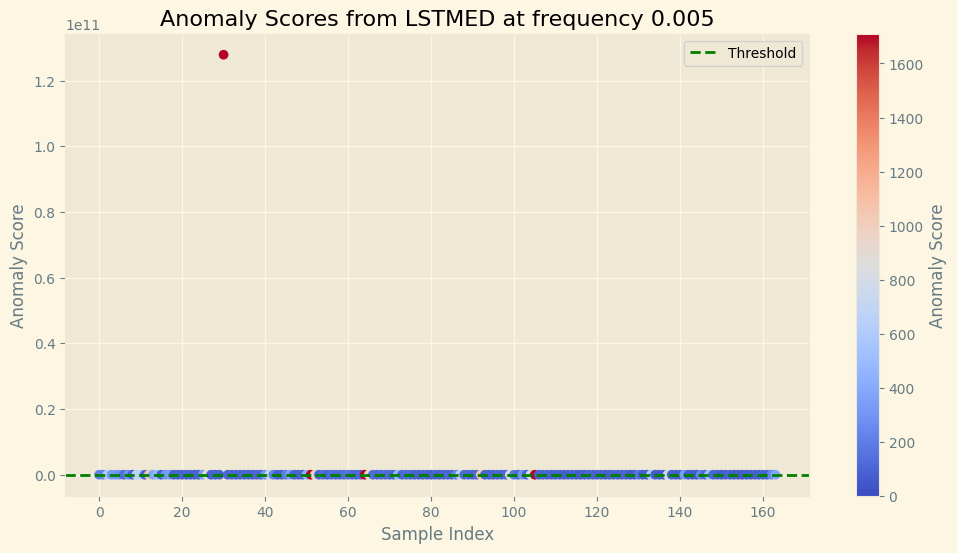

Number of anomalies detected: 9


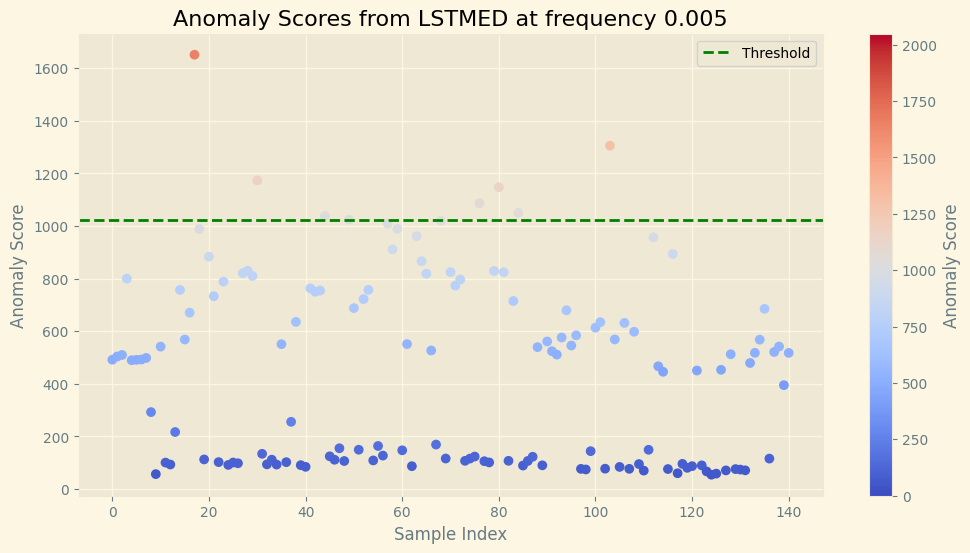

Number of anomalies detected: 7


In [52]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, thresholds[2])
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, thresholds_1[2])
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, thresholds_5[2])

In [53]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(105, 35, 56)

In [54]:
compute_metrics(anomaly_scores, y_collision, thresholds[2])
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, thresholds_1[2])
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, thresholds_5[2])

ROC AUC Score: 0.0286
Detected anomaly class: 0
Threshold: 941.1571
F1 Score: 0.0276
Accuracy: 0.3105
Precision: 0.1875
Recall: 0.0149
              precision    recall  f1-score   support

           0       0.32      0.88      0.47       105
           1       0.19      0.01      0.03       201

    accuracy                           0.31       306
   macro avg       0.25      0.45      0.25       306
weighted avg       0.23      0.31      0.18       306

############################################
ROC AUC Score: 0.0204
Detected anomaly class: 0
Threshold: 855.0793
F1 Score: 0.0145
Accuracy: 0.1707
Precision: 0.1111
Recall: 0.0078
              precision    recall  f1-score   support

           0       0.17      0.77      0.28        35
           1       0.11      0.01      0.01       129

    accuracy                           0.17       164
   macro avg       0.14      0.39      0.15       164
weighted avg       0.12      0.17      0.07       164

###############################

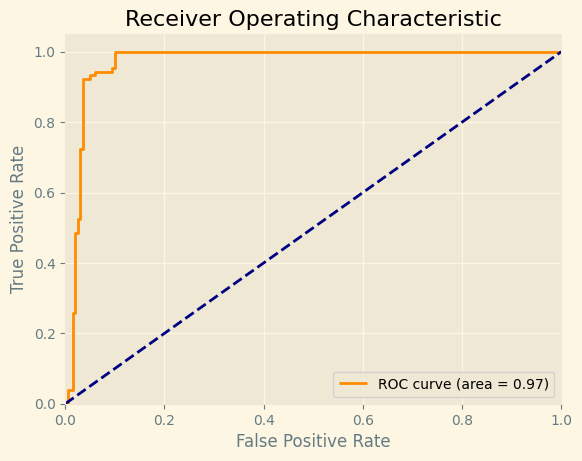

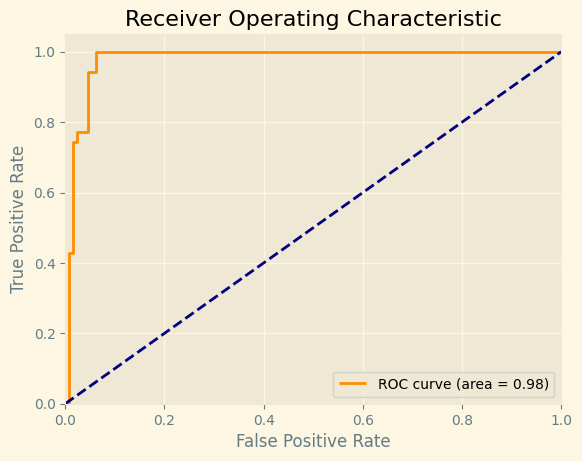

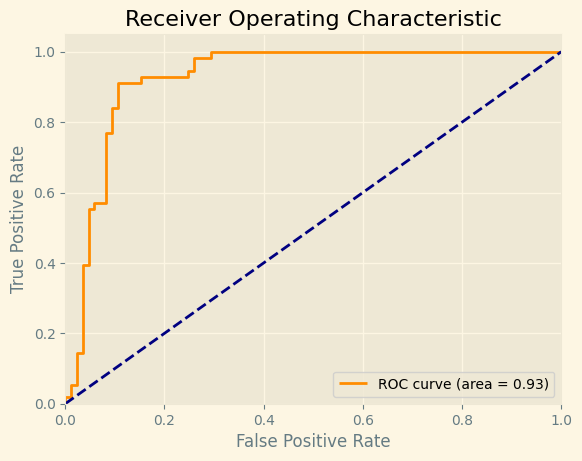

In [55]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

In [ ]:
def plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq):
    # Step 1: Create a DataFrame with the original data and anomaly scores
    df = pd.DataFrame(X_test)
    df['anomaly_score'] = pd.Series(anomaly_scores)

    # Step 2: Add a timestamp column since it doesn't exist
    df['timestamp'] = pd.date_range(start='2022-08-11', periods=len(df), freq='T')
    
    # Step 3: Select a few features to plot along with the anomaly scores
    features_to_plot = df.columns.drop(['anomaly_score', 'timestamp'])

    # Step 4: Create the plot
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.set_title(f'Time Series Data with Anomaly Scores at frequency {freq}', fontsize=16)
    
    # Plot features on primary y-axis
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Feature Values')
    
    colors = plt.cm.Greys(np.linspace(0, 1, len(features_to_plot)))
    for feature, color in zip(features_to_plot, colors):
        ax1.plot(df['timestamp'], df[feature], label=f'Feature: {feature}', linewidth=1, color=color, alpha=0.7)

    # Plot anomaly scores on secondary y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Anomaly Score', color='red')
    ax2.plot(df['timestamp'], df['anomaly_score'], color='red', label='Anomaly Score', linestyle='--', linewidth=1)
    ax2.tick_params(axis='y', labelcolor='red')

    # Highlight top N anomalies
    N = anomalies_detected
    top_anomalies = df.nlargest(N, 'anomaly_score')
    for time in top_anomalies['timestamp']:
        ax1.axvline(x=time, color='green', linestyle='--', alpha=0.7, linewidth=1, label='Detected Anomaly (Top N)')
    
    fig.tight_layout()
    plt.show()

    # Print details of top anomalies
    print("Top", N, "Anomalies:")
    print(top_anomalies[['timestamp', 'anomaly_score'] + list(features_to_plot)])

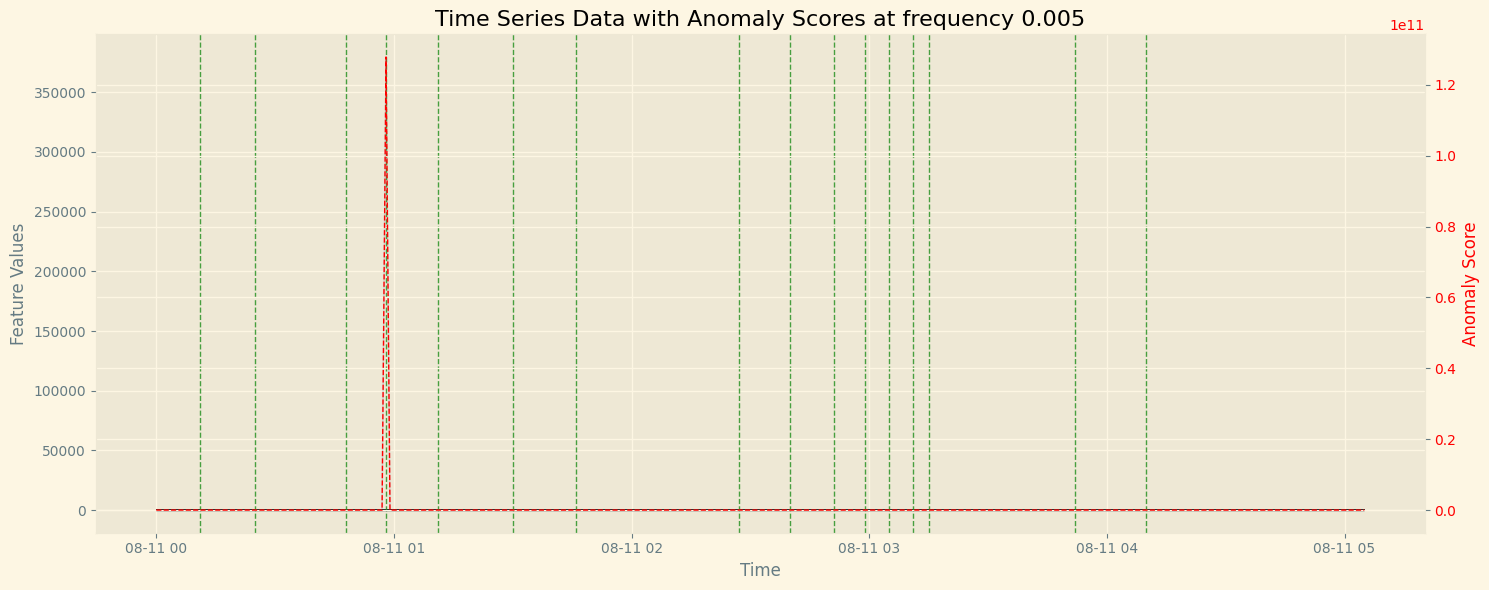

Top 16 Anomalies:
              timestamp  anomaly_score  \
58  2022-08-11 00:58:00   1.278548e+11   
90  2022-08-11 01:30:00   2.048548e+03   
106 2022-08-11 01:46:00   1.912549e+03   
185 2022-08-11 03:05:00   1.754563e+03   
48  2022-08-11 00:48:00   1.596525e+03   
232 2022-08-11 03:52:00   1.303433e+03   
11  2022-08-11 00:11:00   1.218802e+03   
191 2022-08-11 03:11:00   1.129250e+03   
195 2022-08-11 03:15:00   1.051075e+03   
71  2022-08-11 01:11:00   1.045932e+03   
25  2022-08-11 00:25:00   1.032184e+03   
179 2022-08-11 02:59:00   1.031105e+03   
160 2022-08-11 02:40:00   9.696264e+02   
250 2022-08-11 04:10:00   9.526064e+02   
171 2022-08-11 02:51:00   9.470531e+02   
147 2022-08-11 02:27:00   9.413365e+02   

     machine_nameKuka Robot_apparent_power-_Average power  \
58                                            0.588671      
90                                           -1.065532      
106                                          -1.820113      
185                    

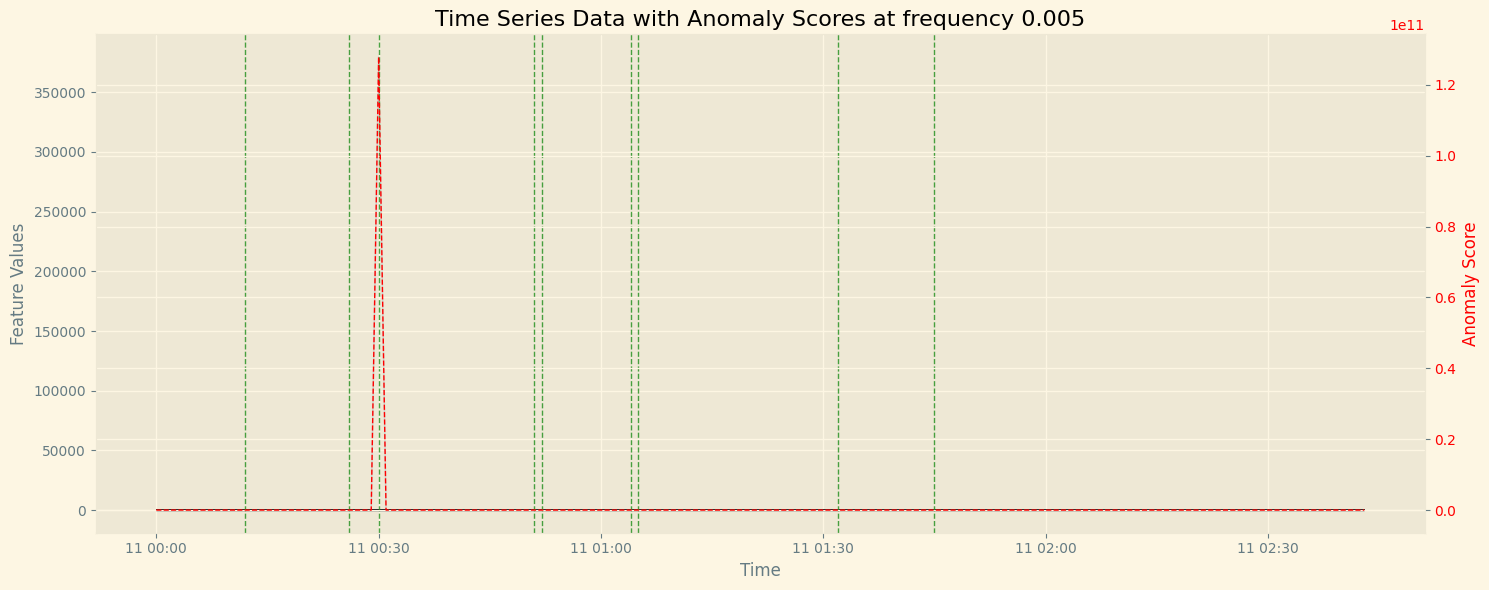

Top 9 Anomalies:
              timestamp  anomaly_score  \
30  2022-08-11 00:30:00   1.278549e+11   
64  2022-08-11 01:04:00   2.367883e+03   
51  2022-08-11 00:51:00   2.084497e+03   
105 2022-08-11 01:45:00   1.788577e+03   
92  2022-08-11 01:32:00   1.057687e+03   
12  2022-08-11 00:12:00   1.048413e+03   
52  2022-08-11 00:52:00   9.486843e+02   
65  2022-08-11 01:05:00   9.180440e+02   
26  2022-08-11 00:26:00   8.580338e+02   

     machine_nameKuka Robot_apparent_power-_Average power  \
30                                            0.588671      
64                                           -1.820113      
51                                           -1.065532      
105                                          -1.005507      
92                                           -0.457819      
12                                           -0.927202      
52                                           -1.101957      
65                                           -1.153266      
26           

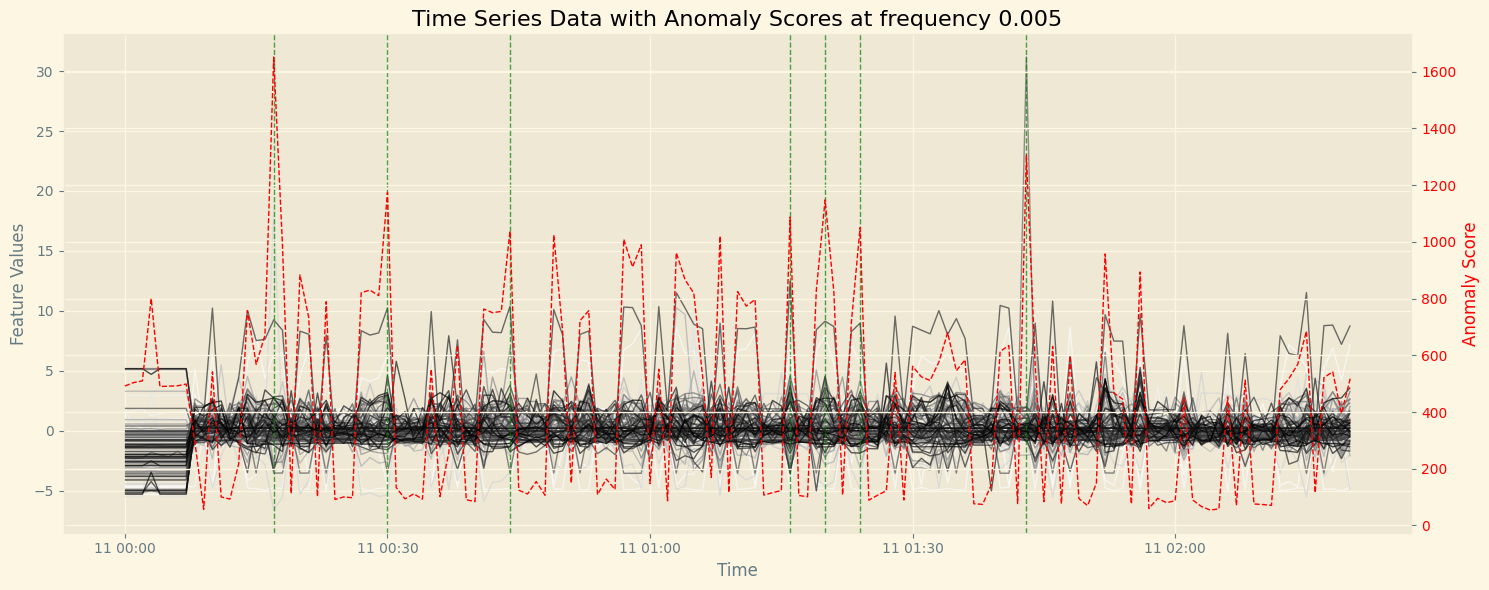

Top 7 Anomalies:
              timestamp  anomaly_score  \
17  2022-08-11 00:17:00    1651.577171   
103 2022-08-11 01:43:00    1305.660932   
30  2022-08-11 00:30:00    1173.804955   
80  2022-08-11 01:20:00    1147.913252   
76  2022-08-11 01:16:00    1087.068437   
84  2022-08-11 01:24:00    1049.985254   
44  2022-08-11 00:44:00    1038.057887   

     machine_nameKuka Robot_apparent_power-_Average power  \
17                                           -0.695126      
103                                           0.063295      
30                                           -1.308804      
80                                           -1.045840      
76                                           -1.281519      
84                                           -1.773366      
44                                           -0.825115      

     machine_nameKuka Robot_current-_Min  \
17                              0.290494   
103                            -0.964452   
30                       

In [56]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)
plot_anomalies_over_time(X_test1, anomaly_scores1, anomalies_detected1, freq)
plot_anomalies_over_time(X_test5, anomaly_scores5, anomalies_detected5, freq)